# Re-entry trajectory using custom aerodynamic guidance

## Objectives

This examples focuses on the application of aerodynamic guidance in the context of a re-entry trajectory of the Space Transportation System (STS).

The aerodynamic guidance updates the angle of attack and the bank angle of the vehicle based on its flight conditions.
The angle of attack is set to 40deg for a Mach number above 12, to 10deg for a Mach number below 6, and varies linearly between them. The bank angle is computed such that the derivative of the flight path angle over time equals 0, and the flight path angle is then constant.
To do so, this example also showcases how to extract and use the flight condition
and body properties during the simulation.

The initial state of the STS is most notably its initial altitude of 120km, velocity of 7.5km/s, and its flight path angle of -0.6deg.

A high number of dependent variable are also propagated in this example. All of them are then plotted at the end of this script.

## Import statements

The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment_setup, environment, propagation_setup, propagation, simulator
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime

## Aerodynamic guidance class

First of all, let's  create a class that contains the aerodynamic guidance. This class needs to be inherited from `propagation.AerodynamicGuidance`.

During the initialisation of this class, the current system of simulated bodies will have to be input.

Then, the class must contain an `updateGuidance()` function that will be called at each simulation time step, taking the time as an input.
Most importantly, this function updates both the angle of attack (`self.angle_of_attack`) and bank angle (`self.bank_angle`) of the vehicle.

The angle of attack $\alpha$ should be updated as a function of the Mach number $M$ as follows:

- $\alpha = 40$ deg if $M > 12$.
- $\alpha = 10$ deg if $M < 6$.
- $\alpha$ varies linearly between the two boundaries for other $M$.

In practice, the following Logistic function is used so that the transition in $\alpha$ between $M=12$ and $M=6$ is smoother:
$$
\alpha = \frac{30}{1 + e^{-2 (M-9) }} + 10
$$

The bank angle $\sigma$ is computed so that, ideally, the flight path angle $\gamma$ should stay constant over time ($\dot{\gamma} = 0$).
The change in flight path angle over time $\dot{\gamma}$ is related to the bank angle $\sigma$ trough the equation below. We thus compute $\sigma$ so that this equation equals 0.
$$
V \dot{\gamma} = \frac{L}{m} \cos \sigma - \left( g_d - \frac{V^2}{r} \right) \cos \gamma + 2 \omega_E V \cos \delta \sin \chi + \omega^2_E r \cos \delta (\cos \delta \cos \gamma + \sin \gamma \sin \delta \cos \chi)
$$
In this equation, $\chi$ and $\delta$ are the heading and latitude angles. $L$, $m$, $V$, and $\omega_E$ are the lift force, vehicle mass, airspeed, and Earth rotation rate. $g_d$ is the downwards (towards the centre of Earth) component of the gravitational acceleration. All of these values are either directly obtained or computed from the flight conditions, the aerodynamic coefficient interface, or the aerodynamic coefficient interface.

In [3]:
# Create a class for the aerodynamic guidance of the STS, inheriting from 'propagation.AerodynamicGuidance'
class STSAerodynamicGuidance:

    def __init__(self, bodies: environment.SystemOfBodies):

        # Extract the STS and Earth bodies
        self.vehicle = bodies.get_body("STS")
        self.earth = bodies.get_body("Earth")

        # Extract the STS flight conditions, angle calculator, and aerodynamic coefficient interface
        environment_setup.add_flight_conditions( bodies, 'STS', 'Earth' )
        self.vehicle_flight_conditions = bodies.get_body("STS").flight_conditions
        self.aerodynamic_angle_calculator = self.vehicle_flight_conditions.aerodynamic_angle_calculator
        self.aerodynamic_coefficient_interface = self.vehicle_flight_conditions.aerodynamic_coefficient_interface

        self.current_time = float("NaN")

    def getAerodynamicAngles(self, current_time: float):
        self.updateGuidance( current_time )
        return np.array([self.angle_of_attack, 0.0, self.bank_angle])

    # Function that is called at each simulation time step to update the ideal bank angle of the vehicle
    def updateGuidance(self, current_time: float):

        if( math.isnan( current_time ) ):
            self.current_time = float("NaN")
        elif( current_time != self.current_time ):
            # Get the (constant) angular velocity of the Earth body
            earth_angular_velocity = np.linalg.norm(self.earth.body_fixed_angular_velocity)
            # Get the distance between the vehicle and the Earth bodies
            earth_distance = np.linalg.norm(self.vehicle.position)
            # Get the (constant) mass of the vehicle body
            body_mass = self.vehicle.mass

            # Extract the current Mach number, airspeed, and air density from the flight conditions
            mach_number = self.vehicle_flight_conditions.mach_number
            airspeed = self.vehicle_flight_conditions.airspeed
            density = self.vehicle_flight_conditions.density

            # Set the current Angle of Attack (AoA). The following line enforces the followings:
            # * the AoA is constant at 40deg when the Mach number is above 12
            # * the AoA is constant at 10deg when the Mach number is below 6
            # * the AoA varies close to linearly when the Mach number is between 12 and 6
            # * a Logistic relation is used so that the transition in AoA between M=12 and M=6 is smoother
            self.angle_of_attack = np.deg2rad(30 / (1 + np.exp(-2*(mach_number-9))) + 10)

            # Update the variables on which the aerodynamic coefficients are based (AoA and Mach)
            current_aerodynamics_independent_variables = [self.angle_of_attack, mach_number]
            
            # Update the aerodynamic coefficients
            self.aerodynamic_coefficient_interface.update_coefficients(
                current_aerodynamics_independent_variables, current_time)

            # Extract the current force coefficients (in order: C_D, C_S, C_L)
            current_force_coefficients = self.aerodynamic_coefficient_interface.current_force_coefficients
            # Extract the (constant) reference area of the vehicle
            aerodynamic_reference_area = self.aerodynamic_coefficient_interface.reference_area

            # Get the heading, flight path, and latitude angles from the aerodynamic angle calculator
            heading = self.aerodynamic_angle_calculator.get_angle(environment_setup.aerodynamic_coefficients.AerodynamicsReferenceFrameAngles.heading_angle)
            flight_path_angle = self.aerodynamic_angle_calculator.get_angle(environment_setup.aerodynamic_coefficients.AerodynamicsReferenceFrameAngles.flight_path_angle)
            latitude = self.aerodynamic_angle_calculator.get_angle(environment_setup.aerodynamic_coefficients.AerodynamicsReferenceFrameAngles.latitude_angle)

            # Compute the acceleration caused by Lift
            lift_acceleration = 0.5 * density * airspeed ** 2 * aerodynamic_reference_area * current_force_coefficients[2] / body_mass
            # Compute the gravitational acceleration
            downward_gravitational_acceleration = self.earth.gravitational_parameter / (earth_distance ** 2)
            # Compute the centrifugal acceleration
            spacecraft_centrifugal_acceleration = airspeed ** 2 / earth_distance
            # Compute the Coriolis acceleration
            coriolis_acceleration = 2 * earth_angular_velocity * airspeed * np.cos(latitude) * np.sin(heading)
            # Compute the centrifugal acceleration from the Earth
            earth_centrifugal_acceleration = earth_angular_velocity ** 2 * earth_distance * np.cos(latitude) *             (np.cos(latitude) * np.cos(flight_path_angle) + np.sin(flight_path_angle) * np.sin(latitude) * np.cos(heading))

            # Compute the cosine of the ideal bank angle
            cosine_of_bank_angle = ((downward_gravitational_acceleration - spacecraft_centrifugal_acceleration) * np.cos(flight_path_angle) - coriolis_acceleration - earth_centrifugal_acceleration) / lift_acceleration
            # If the cosine lead to a value out of the [-1, 1] range, set to bank angle to 0deg or 180deg
            if (cosine_of_bank_angle < -1):
                self.bank_angle = np.pi
            elif (cosine_of_bank_angle > 1):
                self.bank_angle = 0.0
            else:
                # If the cos is in the correct range, return the computed bank angle
                self.bank_angle = np.arccos(cosine_of_bank_angle)
            self.current_time = current_time

## Configuration

NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `0`, corresponding to the 1st of January 2000. The times should be specified in seconds since J2000.
Please refer to the [API documentation](https://py.api.tudat.space/en/latest/time_representation.html) of the `time_representation` module for more information on this.

In [ ]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start epoch (January the 1st, 2000 plus 6000s)
simulation_start_epoch = DateTime(2000, 1, 1, 1, 40).to_epoch()

# Set the maximum simulation time (avoid very long skipping re-entry)
max_simulation_time = 3*constants.JULIAN_DAY


# ## Environment setup
# 
# Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.
# 

### Create the bodies

Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refer to the [Available Environment Models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/environment_models.html#available-model-types) in the user guide for more details.

In [5]:
# Create default body settings for "Earth"
bodies_to_create = ["Earth"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

### Create the vehicle

Let's now create the 5000kg vehicle for which Earth re-entry trajectory will be simulated.

In [6]:
# Create empty body settings for the satellite
body_settings.add_empty_settings("STS")

body_settings.get("STS").constant_mass = 5000


### Add an aerodynamic coefficient interface

An aerodynamic coefficient interface is now added to the STS vehicle. These coefficients are interpolated from files that tabulate them as a function of angle of attack and Mach number.

In [7]:
# Define the aerodynamic coefficient files (leave C_S empty)
aero_coefficients_files = {0: "input/STS_CD.dat", 2:"input/STS_CL.dat"}

# Setup the aerodynamic coefficients settings tabulated from the files
#coefficient_settings = environment_setup.aerodynamic_coefficients.tabulated_force_only_from_files(
#    force_coefficient_files=aero_coefficients_files,
#    reference_area=2690.0*0.3048*0.3048,
#    independent_variable_names=[environment.angle_of_attack_dependent, environment.mach_number_dependent],
#    are_coefficients_in_aerodynamic_frame=True,
#    are_coefficients_in_negative_axis_direction=True
#)

# Setup the aerodynamic coefficients settings tabulated from the files
coefficient_settings = environment_setup.aerodynamic_coefficients.tabulated_force_only_from_files(
    force_coefficient_files=aero_coefficients_files,
    reference_area=2690.0*0.3048*0.3048,
    independent_variable_names=[environment_setup.aerodynamic_coefficients.AerodynamicCoefficientsIndependentVariables.angle_of_attack_dependent, environment_setup.aerodynamic_coefficients.AerodynamicCoefficientsIndependentVariables.mach_number_dependent],
)

# Add predefined aerodynamic coefficients database to the body
body_settings.get("STS").aerodynamic_coefficient_settings = coefficient_settings


The system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [8]:
# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Add rotation model based on aerodynamic guidance

In [9]:
# ### Add rotation model based on aerodynamic guidance
# Create the aerodynamic guidance object
aerodynamic_guidance_object = STSAerodynamicGuidance(bodies)
rotation_model_settings = environment_setup.rotation_model.aerodynamic_angle_based(
    'Earth', '', 'STS_Fixed', aerodynamic_guidance_object.getAerodynamicAngles )
environment_setup.add_rotation_model( bodies, 'STS', rotation_model_settings )

## Propagation setup

Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [10]:
# Define bodies that are propagated
bodies_to_propagate = ["STS"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model

The acceleration settings that act on the `STS` vehicle are now defined.
In this case, these simply consist in the Earth gravitational effect modelled as a point mass and of the aerodynamic acceleration of the Earth atmosphere.

The acceleration settings defined are then applied to `STS` vehicle in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [11]:
# Define the accelerations acting on the STS (Earth as a Point Mass, and Earth's atmosphere)
accelerations_settings_STS = dict(
    Earth=[
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.aerodynamic(),
    ]
)

acceleration_settings = {"STS": accelerations_settings_STS}

# Create the acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Define the initial state

The initial state of the vehicle that will be propagated is now defined. Most importantly, the `STS` vehicle starts 120km above Earth, at a velocity og 7500m/s, and a flight path angle of -0.6 deg (from the horizon).

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `spherical_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Spherical elements, and then converted in Cartesian elements.

Finally, the initial state has to be converted from the Earth-fixed frame in which it is defined with the Spherical elements to the inertial frame.

In [12]:
# Set the initial state of the STS as spherical elements, and convert them to a cartesian state
initial_radial_distance = bodies.get_body("Earth").shape_model.average_radius + 120e3

# Convert the initial state
initial_earth_fixed_state = element_conversion.spherical_to_cartesian_elementwise(
    radial_distance=initial_radial_distance,
    latitude=np.deg2rad(20),
    longitude=np.deg2rad(140),
    speed=7.5e3,
    flight_path_angle=np.deg2rad(-0.6),
    heading_angle=np.deg2rad(15),
)

# Convert the state from the Earth-fixed frame to the inertial frame
earth_rotation_model = bodies.get_body("Earth").rotation_model
initial_state = environment.transform_to_inertial_orientation(
    initial_earth_fixed_state, simulation_start_epoch, earth_rotation_model
)

### Define the dependent variables to save

In this example, we are interested in saving not only the propagated state of the vehicle over time, but also a set of so-called dependent variables, that are to be computed (or extracted and saved) at each integration step.

[This page](https://py.api.tudat.space/en/latest/dependent_variable.html) of the tudatpy API website provides a detailed explanation of all the dependent variables that are available.

In [13]:
# Define the list of dependent variables to save during the propagation
dependent_variables_to_save = [
    propagation_setup.dependent_variable.flight_path_angle("STS", "Earth"),
    propagation_setup.dependent_variable.altitude("STS", "Earth"),
    propagation_setup.dependent_variable.bank_angle("STS", "Earth"),
    propagation_setup.dependent_variable.angle_of_attack("STS", "Earth"),
    propagation_setup.dependent_variable.aerodynamic_force_coefficients("STS"),
    propagation_setup.dependent_variable.airspeed("STS", "Earth"),
    propagation_setup.dependent_variable.total_acceleration_norm("STS"),
    propagation_setup.dependent_variable.mach_number("STS", "Earth")
]

### Create the propagator settings

The propagator is finally setup.

First, a termination condition is defined so that the propagation as soon as one of these conditions is fulfilled:

- The altitude gets below 25km.
- The simulation time gets above 3 days.

Combined termination settings are then needed, which can be done using the `propagation_setup.propagator.hybrid_termination()` function.

Subsequently, the integrator settings are defined using a RK4 integrator with the fixed step size of 0.5 seconds.

In [14]:
# Define a termination conditions to stop once altitude goes below 25 km
altitude_limit = 25.0e3
termination_altitude_settings = (
    propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.altitude(
            "STS", "Earth"
        ),
        limit_value=altitude_limit,
        use_as_lower_limit=True,
    )
)
# Define a termination condition to stop after a given time (to avoid an endless skipping re-entry)
termination_time_settings = propagation_setup.propagator.time_termination(simulation_start_epoch + max_simulation_time)
# Combine the termination settings to stop when one of them is fulfilled
termination_conditions = [termination_altitude_settings, termination_time_settings]
# Add string representations of the termination conditions
termination_conditions_repr = [
    f"Altitude Termination at {altitude_limit/1e3}km",
    "Time Termination",
]

combined_termination_settings = propagation_setup.propagator.hybrid_termination(
    termination_conditions, fulfill_single_condition=True
)

# Create numerical integrator settings
fixed_step_size = 0.5
integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
    fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
)

# Create the propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    combined_termination_settings,
    output_variables=dependent_variables_to_save
)

## Propagate the trajectory

The re-entry trajectory is now ready to be propagated.

This is done by calling the `create_dynamics_simulator()` function of the `dynamics.simulator module`.
This function requires the `bodies` and `propagator_settings` that have all been defined earlier.

After this, the dependent variable history is extracted.
The column indexes corresponding to a given dependent variable in the `dep_vars` variable are printed when the simulation is run, when `create_dynamics_simulator()` is called.
Do mind that converting to an ndarray using the `result2array()` utility will shift these indexes, since the first column (index 0) will then be the times.

In this example, we are not interested in analysing the state history. This can however be accessed in the `dynamics_simulator.propagation_results.state_history` variable.

In [15]:
# Create the simulation objects and propagate the dynamics
dynamics_simulator = simulator.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting simulation dependent variables
dependent_variables = dynamics_simulator.propagation_results.dependent_variable_history
# Convert the dependent variables from a dictionary to a numpy array
dependent_variables_array = result2array(dependent_variables)

## Post-process the propagation results

The results of the propagation are then processed to a more user-friendly form.

### Termination Condition

First, let's assess which of the two termination conditions that were defined in the `hybrid_termination()` condition triggered the termination of the propagation.
This can be retrieved from the `termination_details` attribute of the `propagation_results` object, which will be an instance of `PropagationTerminationDetailsFromHybridCondition`.

The `PropagationTerminationDetailsFromHybridCondition.was_condition_met_when_stopping` attribute is a list of boolean flags, which signs if each of the defined termination conditions in the `hybrid_termination()` condition was fulfilled.

In [16]:
termination_details = dynamics_simulator.propagation_results.termination_details
condition_met_flags = termination_details.was_condition_met_when_stopping

condition_fulfilled = [
    f"{condition:<35}: {met}"
    for condition, met in zip(termination_conditions_repr, condition_met_flags)
]

print("Termination Conditions fulfilled:")
print("\n".join(condition_fulfilled))

Termination Conditions fulfilled:
Altitude Termination at 25.0km     : True
Time Termination                   : False


### Altitude over time

We can confirm that the propagation was terminated due to the altitude termination condition, by plotting it over the relative propagation time:

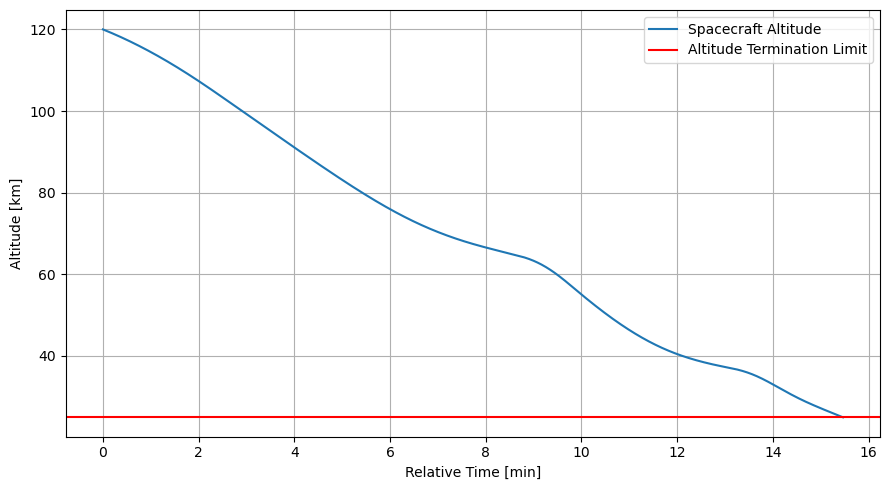

In [17]:
# Extract the time from the dependent variables array (and convert from seconds to minutes)
time_min = (dependent_variables_array[:, 0] - dependent_variables_array[0, 0]) / 60

# Define a matplotlib.pyplot figure
plt.figure(figsize=(9, 5))
# Plot the altitude over time
plt.plot(time_min, dependent_variables_array[:, 2] / 1e3, label="Spacecraft Altitude")
plt.axhline(altitude_limit / 1e3, color="r", label="Altitude Termination Limit")
plt.legend()
# Add label to the axis
plt.xlabel("Relative Time [min]"), plt.ylabel("Altitude [km]")
# Add a grid
plt.grid()
# Use a tight layout to save space
plt.tight_layout()
plt.show()

### Airspeed vs altitude

Let's now plot the altitude of the vehicle as a function of its airspeed. This gives insights into how the vehicle decelerates.

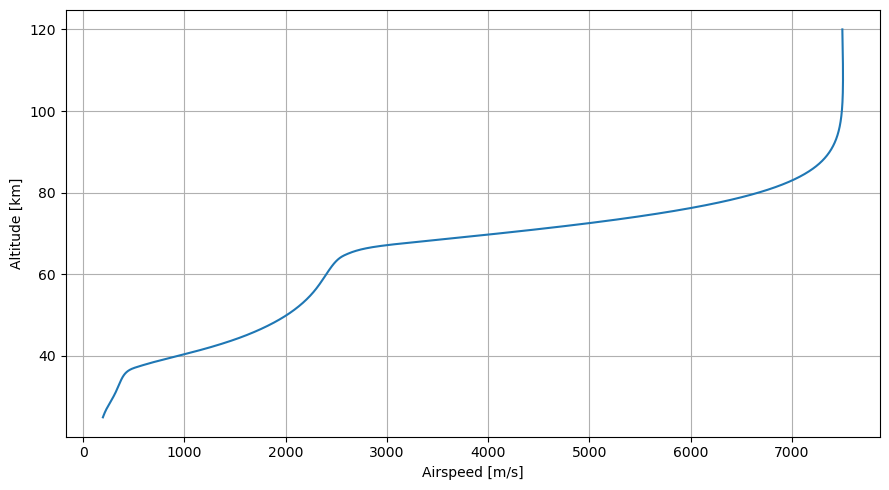

In [18]:
# Plot the airspeed vs altitude
plt.figure(figsize=(9, 5))
plt.plot(dependent_variables_array[:,8], dependent_variables_array[:,2]/1e3)
plt.xlabel("Airspeed [m/s]"), plt.ylabel("Altitude [km]")
plt.grid()
plt.tight_layout()
plt.show()

### g-load over time

The following plot then shows the total acceleration on the vehicle in `g` (Earth's gravitational acceleration at sea level).

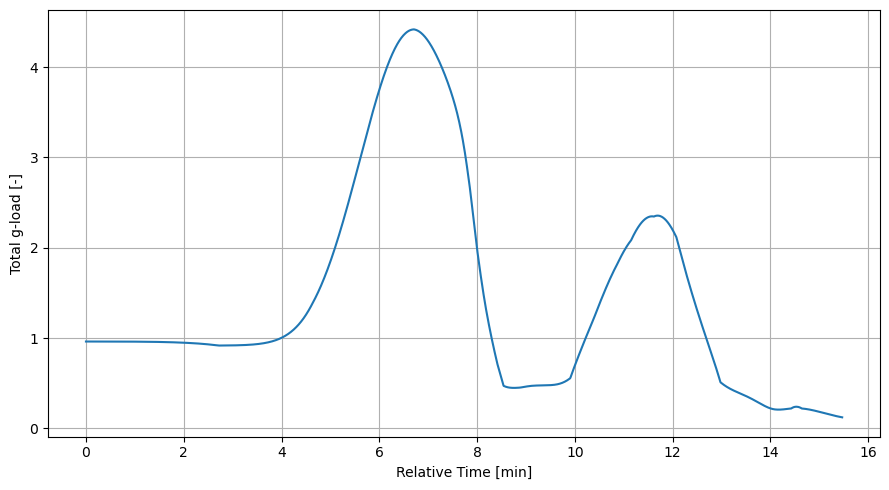

In [19]:
# Plot the g-load over time
plt.figure(figsize=(9, 5))
plt.plot(time_min, dependent_variables_array[:, 9] / 9.81)
plt.xlabel("Relative Time [min]"), plt.ylabel("Total g-load [-]")
plt.grid()
plt.tight_layout()
plt.show()

### Aerodynamic coefficient over time

Plotting the aerodynamic coefficients over time can also give a good set of insights into what happens during re-entry.

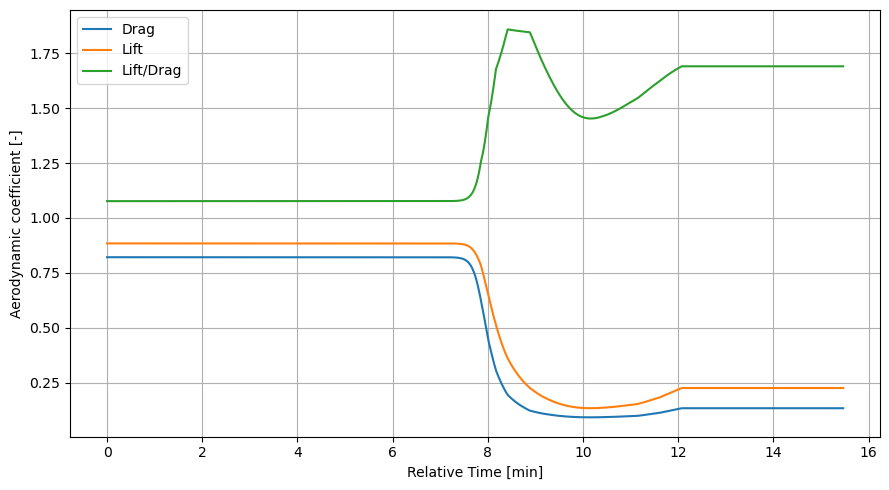

In [20]:
# Plot C_D, C_L, and L/D over time
plt.figure(figsize=(9, 5))
plt.plot(time_min, dependent_variables_array[:,5], label="Drag")
plt.plot(time_min, dependent_variables_array[:,7], label="Lift")
plt.plot(time_min, dependent_variables_array[:,7]/dependent_variables_array[:,5], label="Lift/Drag")
plt.xlabel("Relative Time [min]"), plt.ylabel("Aerodynamic coefficient [-]")
# Also add a legend
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Angles over time

Plotting the angle of attack and bank angle over time allows to check if the aerodynamic guidance behaves as expected. Moreover, plotting the flight path angle over time allows to check how efficient the guidance was at keeping it constant.

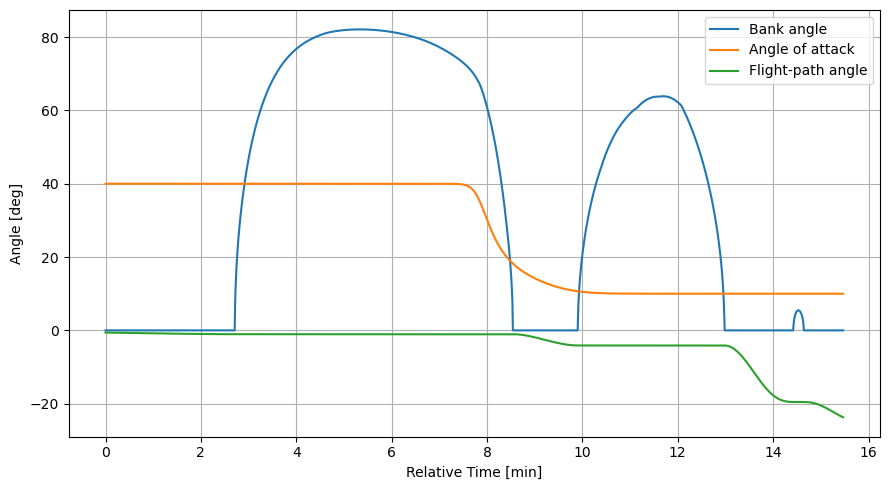

In [21]:
# Plot various angles over time (bank angle, angle of attack, and flight-path angle)
plt.figure(figsize=(9, 5))
plt.plot(time_min, np.rad2deg(dependent_variables_array[:,3]), label="Bank angle")
plt.plot(time_min, np.rad2deg(dependent_variables_array[:,4]), label="Angle of attack")
plt.plot(time_min, np.rad2deg(dependent_variables_array[:,1]), label="Flight-path angle")
plt.xlabel("Relative Time [min]"), plt.ylabel("Angle [deg]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Angle of attack vs Mach number

Plotting the angle of attack as a function of the Mach number allows to check that it indeed is of 10deg below Mach 6, of 40deg above Mach 12, and that it varies more or less linearly (and smoothly) in-between.

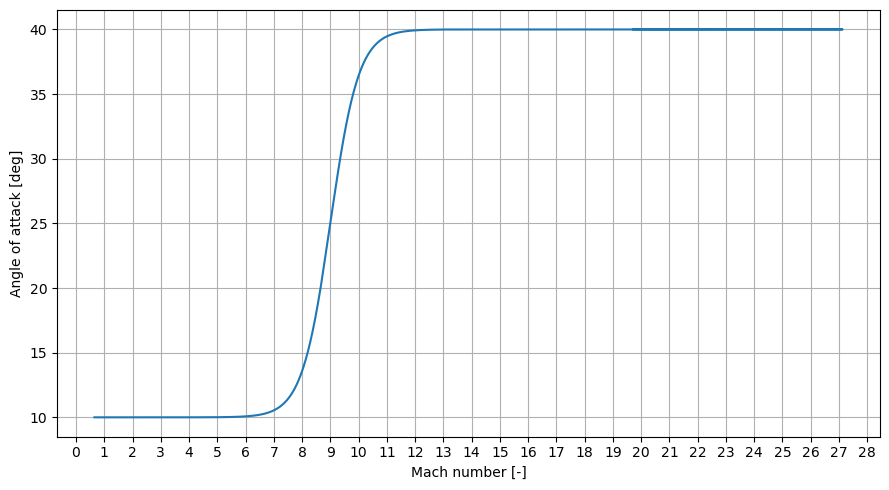

In [22]:
# Plot the AoA over Mach number
plt.figure(figsize=(9, 5))
plt.plot(dependent_variables_array[:,10], np.rad2deg(dependent_variables_array[:,4]))
plt.xlabel("Mach number [-]"), plt.ylabel("Angle of attack [deg]")
# Set the x-axis ticks spacing to 1
plt.xticks(np.arange(0, 28.1, 1))
plt.grid()
plt.tight_layout()
plt.show()

### Derivative of flight path angle over time

Plotting the derivative of the flight path angle over time finally allows to analyse how constant the flight path angle really was.

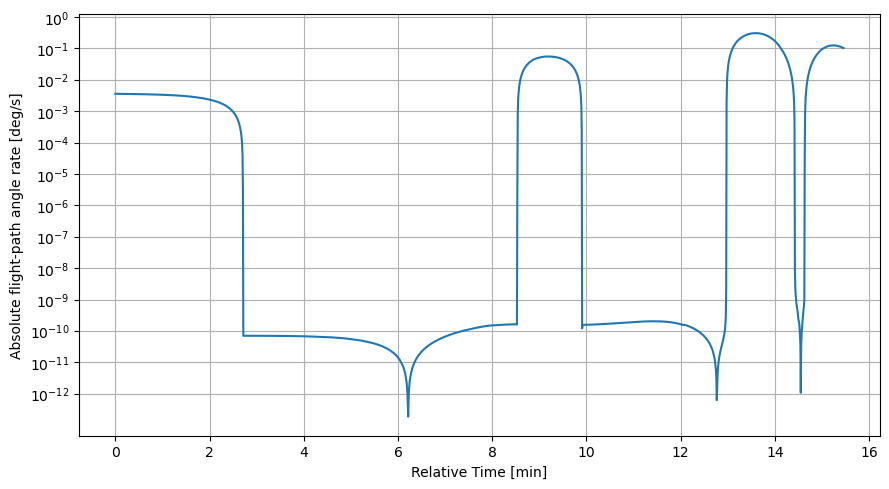

In [23]:
flight_path_angle = dependent_variables_array[:, 1]
# Compute the derivative of the flight path angle over time (dot(gamma) = Delta gamma / Delta t)
flight_path_angle_derivative = np.fabs(( flight_path_angle[1:flight_path_angle.size] - flight_path_angle[0:-1])/fixed_step_size)
# Plot the derivative of the flight path angle over time
plt.figure(figsize=(9, 5))
plt.plot(time_min[0:-1], np.rad2deg(flight_path_angle_derivative))
plt.xlabel("Relative Time [min]"), plt.ylabel("Absolute flight-path angle rate [deg/s]")
# Make the y-axis logarithmic
plt.yscale("log")
# Have a tick on the y-axis every power of 10
plt.yticks(10**np.arange(-12, 0.1, 1))
plt.grid()
plt.tight_layout()
plt.show()